## One Million News Headlines

We are interested in the news headlines topics in the past two decades. What has been on the news?

We use the kaggle dataset that contains news headlines published over a period of seventeen years (2003-2019) by ABC (Australian Broadcasting Corp). 

We also use [this kaggle kernel](https://www.kaggle.com/ktattan/lda-and-document-similarity/notebook) and [this notebook on github](https://github.com/franciscadias/projects/blob/master/ABC_News.ipynb) as reference for data cleaning procedures and looking at top 10 words for the top 10 topics. 

In [1]:
import pandas as pd
import numpy as np

We first load the dataset and see what we have. This csv file is about 58MB in size, so we could consider storing is in a SQL database. Here we load it directly with pandas. 

In [2]:
df = pd.read_csv('abcnews-date-text.csv', parse_dates=['publish_date'])
df.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


We then add columns for the year the headlines were published. This will be used in an analysis later.

In [3]:
df["year"] = df["publish_date"].astype(str).str[:4].astype(np.int64)

All rows with missing data is removed. The dataframe is then shuffled and re-indexed.

In [4]:
df.dropna(axis=0, inplace=True, subset=['headline_text'])

In [5]:
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,publish_date,headline_text,year
0,2004-02-01,elderly man found dead,2004
1,2014-08-28,cairns double murder trial jury starts deliber...,2014
2,2014-06-27,alice spings residents rally to support house ...,2014
3,2008-07-24,jacqui lawrence sibling rivalry makes way for,2008
4,2015-09-03,water shortages force png hospital to send,2015


Import required NLP and text cleaning packages.

In [6]:
from time import time
import re
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


We then clean the headline_text to clear it of websites, email addresses, and punctuation. The text is also made lowercase. After that, we tokenize the text by vectorizing the text corpus. 

A lemmatizer (as opposed to a stemmer) is used here so that we obtain real English words here. The parts of speech (POS) is found by the get_word_pos function. Alternatively, the spaCy lemmatizer can be used.

In [7]:
def clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    return text

#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemma(text):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]

def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

def apply_all(text):
    return lemma(remove_stop_words(clean(text)))

For such a large dataset, the difference in time for stemming and lemmatizing words is quite large. Stemming takes about 4.8min, whereas lemmatizing takes 47min, a 10x difference. Using the first 10000 lines of the dataset takes about 0.45min. 

We can use SpaCy to remove stopwords, limit the part-of-speech (POS) tags, and lemmatize the text. 100000 lines of data takes takes about 4min.

In [8]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
tokenized = []
allowed_pos_tags = ['NOUN','ADJ','VERB','ADV']
t1 = time()
for line in df['headline_text'].head(100000):
    txt = nlp(line)
    b = [t.lemma_ for t in txt if (t.lemma_ not in stop_words) and (t.pos_ in allowed_pos_tags)]
    tokenized.append(b)
t2 = time()
print("Time to clean and tokenize %.2e articles: %.2f min." 
      %( len(tokenized), (t2-t1)/60))

print(tokenized[:5])

Time to clean and tokenize 1.00e+05 articles: 3.84 min.
[['elderly', 'man', 'find', 'dead'], ['double', 'murder', 'trial', 'jury', 'start', 'deliberating'], ['sping', 'resident', 'rally', 'support', 'house', 'fire'], ['make', 'way'], ['water', 'shortage', 'force', 'send']]


In [9]:
dfa = pd.DataFrame()
dfa['text'] = tokenized
dfa.head()

,text
0,"[elderly, man, find, dead]"
1,"[double, murder, trial, jury, start, deliberat..."
2,"[sping, resident, rally, support, house, fire]"
3,"[make, way]"
4,"[water, shortage, force, send]"


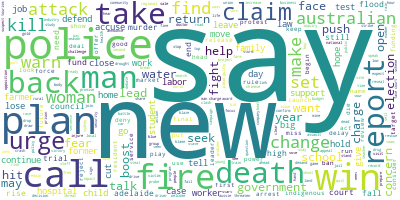

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ' '.join(' '.join(line) for line in dfa.text)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
# t1 = time()
# a= df['headline_text'].head(100000).apply(apply_all)
# t2 = time()
# print("Time to clean and tokenize %.2e articles: %.2f min." %( len(a), (t2-t1)/60))

# a.head(10)

Get word frequency

In [12]:
from nltk import FreqDist

# first get a list of all words
all_words = [word for item in list(tokenized) for word in item]

# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

18168

We use Latent Dirichlet Allocation (LDA), an unsupervised generative model that assigns topic distributions to documents. 

`LDA does not work well with very short documents, like twitter feeds, as explained here [1] [2], which is why we dropped articles under 40 tokens previously. Very briefly, this is because the model infers parameters from observations and if there are not enough observations (words) in a document, the model performs poorly.'

`Unlike the word2vec algorithm, which performs extremely well with full structured sentences, LDA is a bag of words model, meaning word order in a document doesnt count. This also means that stopwords and rare words should be excluded, so that the model doesnt overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.'

In [13]:
import gensim

dictionary = gensim.corpora.Dictionary(dfa['text'])
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in dfa['text']]

In [14]:
t1 = time()
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=10, 
                                       id2word=dictionary,                                    
                                       passes=10,
                                       workers=3)
t2 = time()
print('LDA model trained in %.1f min.' % ((t2-t1)/60))

LDA model trained in 2.1 min.


We save this model.

In [15]:
from gensim.test.utils import datapath
lda_model.save('one_mil_model2')

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.302786  0.077113       1        1  10.777910
6      0.138571 -0.060666       2        1  10.520956
0     -0.334330  0.018472       3        1  10.421007
9      0.133171 -0.090292       4        1  10.315355
8      0.106955  0.045294       5        1  10.050244
1      0.053416  0.240316       6        1   9.929502
2      0.145610  0.027928       7        1   9.675430
3      0.021447 -0.196924       8        1   9.613272
7      0.094935  0.190495       9        1   9.456324
4     -0.056989 -0.251737      10        1   9.240005, topic_info=        Term         Freq        Total Category  logprob  loglift
132      say  2350.000000  2350.000000  Default  30.0000  30.0000
60    police  2963.000000  2963.000000  Default  29.0000  29.0000
94      call  1633.000000  1633.000000  Default  28.0000  28.0000
3        man  2367.000000  2367.000000  Default  27.0000  27.0000
54       win  1445.000000  1445.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
803   debate   223.416122   279.898254  Topic10  -4.9029   2.1562
699  chinese   187.358536   250.706467  Topic10  -5.0790   2.0904
170     kill   303.181366  1219.230591  Topic10  -4.5976   0.9900
207     week   172.763306   280.163330  Topic10  -5.1601   1.8982
48      year   181.558090   993.845642  Topic10  -5.1104   0.6816

[436 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
589      10  0.996471     abuse
1513      6  0.996639  accident
190       3  0.998350    accuse
268       7  0.998863    action
1286      1  0.997386     admit
...     ...       ...       ...
48        3  0.157972      year
48        6  0.065403      year
48        8  0.592647      year
48       10  0.183127      year
731       1  0.998001     youth

[563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 10, 9, 2, 3, 4, 8, 5])

We print the top 10 words of each of the top 10 topics in descending order of importance.

In [17]:
for a, b in lda_model.print_topics(num_topics=-1, num_words=10):
    print('Topic ',a)
    print('---------')
    for word in b.split(' + '):
        num, key = word[:5], word[6:]
        print(key)
    print('\n')

Topic  0
---------
"police"
"court"
"face"
"man"
"murder"
"jail"
"accuse"
"seek"
"miss"
"charge"


Topic  1
---------
"death"
"rise"
"price"
"high"
"rate"
"plan"
"record"
"fall"
"support"
"tax"


Topic  2
---------
"new"
"set"
"claim"
"flood"
"school"
"fight"
"government"
"rain"
"pay"
"action"


Topic  3
---------
"win"
"kill"
"continue"
"health"
"year"
"show"
"student"
"deny"
"sale"
"threat"


Topic  4
---------
"talk"
"home"
"crash"
"return"
"lose"
"driver"
"move"
"name"
"release"
"leader"


Topic  5
---------
"man"
"find"
"charge"
"woman"
"report"
"car"
"die"
"make"
"police"
"drug"


Topic  6
---------
"say"
"change"
"concern"
"could"
"power"
"farmer"
"still"
"fear"
"need"
"business"


Topic  7
---------
"hit"
"water"
"open"
"test"
"want"
"first"
"close"
"cut"
"job"
"consider"


Topic  8
---------
"fire"
"warn"
"get"
"boost"
"may"
"work"
"tell"
"time"
"resident"
"industry"


Topic  9
---------
"call"
"take"
"go"
"election"
"indigenous"
"hold"
"day"
"top"
"put"
"public"




A Scikit-learn implementation using the sklearn CountVectorizer to clean and tokenize the corpus. The same dataset extract (first 100,000 lines) is used here.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

all_words = df.headline_text.head(100000)

In [19]:
vect = CountVectorizer(stop_words="english")
vect.fit(all_words)

CountVectorizer(stop_words='english')

In [20]:
print(len(vect.vocabulary_))

37641


In [21]:
bag_of_words = vect.transform(all_words)

Here we use the online learning method, which differs from the batch learning method. 

In [22]:
lda = LatentDirichletAllocation(n_components=10, learning_method="online",
                                max_iter=10, random_state=0, n_jobs=3, 
                                verbose=0)
# be build the model and transform the data in one step
# computing transform takes some time,
# and we can save time by doing both at once.
document_topics = lda.fit_transform(bag_of_words)

In [23]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

Print out the 10 topics. Running mglearn requires sklearn <= 0.22

In [26]:
import mglearn
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

ModuleNotFoundError: No module named 'sklearn.externals.six'

We can also look at how often the news articles are published.

In [27]:
df.head(10)

,publish_date,headline_text,year
0,2004-02-01,elderly man found dead,2004
1,2014-08-28,cairns double murder trial jury starts deliber...,2014
2,2014-06-27,alice spings residents rally to support house ...,2014
3,2008-07-24,jacqui lawrence sibling rivalry makes way for,2008
4,2015-09-03,water shortages force png hospital to send,2015
5,2003-06-01,glory facing player exodus,2003
6,2003-12-28,troops dead in iraq blasts,2003
7,2015-06-19,federal road funding not enough for northern r...,2015
8,2008-12-23,rta flooded with highway upgrade submissions,2008
9,2011-05-22,anti planker hurt in planking demo,2011


In [28]:
df.year.unique()

array([2004, 2014, 2008, 2015, 2003, 2011, 2006, 2009, 2007, 2005, 2013,
       2018, 2017, 2019, 2012, 2016, 2010], dtype=int64)

In [29]:
df.head(-10)

,publish_date,headline_text,year
0,2004-02-01,elderly man found dead,2004
1,2014-08-28,cairns double murder trial jury starts deliber...,2014
2,2014-06-27,alice spings residents rally to support house ...,2014
3,2008-07-24,jacqui lawrence sibling rivalry makes way for,2008
4,2015-09-03,water shortages force png hospital to send,2015
...,...,...,...
1186003,2013-07-31,icac findings,2013
1186004,2003-07-28,water pipeline to go ahead,2003
1186005,2006-07-15,greens say act planning laws remove public input,2006
1186006,2008-12-08,property tax bills outrageousbuswell,2008


In [30]:
dfa = df.groupby('year')['headline_text'].count()
dfa

year
2003    63997
2004    72674
2005    73124
2006    66901
2007    77174
2008    79991
2009    76444
2010    74931
2011    77778
2012    89008
2013    91928
2014    81531
2015    77290
2016    61574
2017    47511
2018    40102
2019    34060
Name: headline_text, dtype: int64

In [31]:
#Index the date
df = df.set_index('publish_date')
df.index

DatetimeIndex(['2004-02-01', '2014-08-28', '2014-06-27', '2008-07-24',
               '2015-09-03', '2003-06-01', '2003-12-28', '2015-06-19',
               '2008-12-23', '2011-05-22',
               ...
               '2010-04-20', '2013-01-02', '2015-02-13', '2007-10-11',
               '2019-12-04', '2012-10-11', '2011-01-04', '2011-10-04',
               '2017-03-16', '2013-03-19'],
              dtype='datetime64[ns]', name='publish_date', length=1186018, freq=None)

We can resample the publish dates and aggregate by the month.

In [32]:
y = df['headline_text'].resample('MS').count()
y

publish_date
2003-02-01    2180
2003-03-01    6410
2003-04-01    6101
2003-05-01    6399
2003-06-01    6346
              ... 
2019-08-01    2953
2019-09-01    2828
2019-10-01    3016
2019-11-01    2768
2019-12-01    2471
Freq: MS, Name: headline_text, Length: 203, dtype: int64

C:\test\lib\site-packages\ipywidgets\widgets\widget_selection.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Iterable
C:\test\lib\site-packages\ipywidgets\widgets\widget_selection.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Iterable


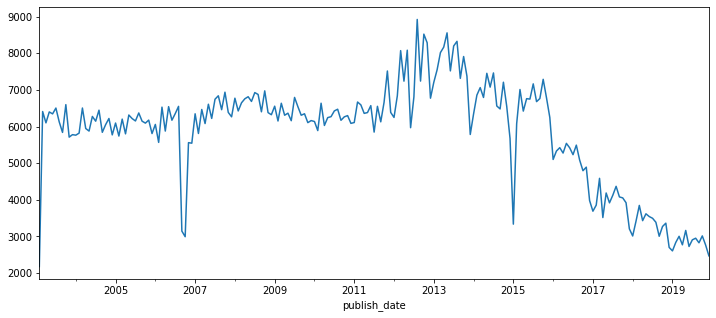

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

y.plot(figsize=(12,5))
plt.show()